In [1]:
import warnings
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from statsmodels.stats.diagnostic import het_breuschpagan
from sqlalchemy import create_engine

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

from IPython.display import display_html

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import VarianceThreshold

In [3]:
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [4]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")


def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

In [5]:
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)


def top_corrs(df, column, n=20):
    corr_df = df.corr()[[column]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()

    top_n_num = corr_df.sort_values("abs_corr", ascending=False).head(20)
    return top_n_num


def plot_top_corrs(df, column, n=10):
    top_corrs_df = top_corrs(df, column, n)
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()


def na_summary(df, group_col, additional_cols=None):
    if additional_cols is None:
        additional_cols = ["log_saleprice"]

    additional_cols.append(group_col)
    # fmt: off
    df = (
      df[additional_cols]
        .fillna("NaN")
        .groupby(group_col)
        .agg(["size", "mean", "sum"])
    )
    display(df)
    # fmt: on


In [6]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# No need for an open connection, because only doing a single query
engine.dispose()


df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,nan,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [7]:
df['mssubclass'].corr(df['lotfrontage'])

-0.3863468853449289

Based on previous work on this dataset, 5 variables are missing too much data and are not strongly correlated with saleprice so they are removed from dataset. 

In [8]:
df.shape

(1460, 81)

SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
MSSubClass: The building class
MSZoning: The general zoning classification
LotFrontage: Linear feet of street connected to property
LotArea: Lot size in square feet
Street: Type of road access
Alley: Type of alley access
LotShape: General shape of property
LandContour: Flatness of the property
Utilities: Type of utilities available
LotConfig: Lot configuration
LandSlope: Slope of property
Neighborhood: Physical locations within Ames city limits
Condition1: Proximity to main road or railroad
Condition2: Proximity to main road or railroad (if a second is present)
BldgType: Type of dwelling
HouseStyle: Style of dwelling
OverallQual: Overall material and finish quality
OverallCond: Overall condition rating
YearBuilt: Original construction date
YearRemodAdd: Remodel date
RoofStyle: Type of roof
RoofMatl: Roof material
Exterior1st: Exterior covering on house
Exterior2nd: Exterior covering on house (if more than one material)
MasVnrType: Masonry veneer type
MasVnrArea: Masonry veneer area in square feet
ExterQual: Exterior material quality
ExterCond: Present condition of the material on the exterior
Foundation: Type of foundation
BsmtQual: Height of the basement
BsmtCond: General condition of the basement
BsmtExposure: Walkout or garden level basement walls
BsmtFinType1: Quality of basement finished area
BsmtFinSF1: Type 1 finished square feet
BsmtFinType2: Quality of second finished area (if present)
BsmtFinSF2: Type 2 finished square feet
BsmtUnfSF: Unfinished square feet of basement area
TotalBsmtSF: Total square feet of basement area
Heating: Type of heating
HeatingQC: Heating quality and condition
CentralAir: Central air conditioning
Electrical: Electrical system
1stFlrSF: First Floor square feet
2ndFlrSF: Second floor square feet
LowQualFinSF: Low quality finished square feet (all floors)
GrLivArea: Above grade (ground) living area square feet
BsmtFullBath: Basement full bathrooms
BsmtHalfBath: Basement half bathrooms
FullBath: Full bathrooms above grade
HalfBath: Half baths above grade
Bedroom: Number of bedrooms above basement level
Kitchen: Number of kitchens
KitchenQual: Kitchen quality
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
Functional: Home functionality rating
Fireplaces: Number of fireplaces
FireplaceQu: Fireplace quality
GarageType: Garage location
GarageYrBlt: Year garage was built
GarageFinish: Interior finish of the garage
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet
GarageQual: Garage quality
GarageCond: Garage condition
PavedDrive: Paved driveway
WoodDeckSF: Wood deck area in square feet
OpenPorchSF: Open porch area in square feet
EnclosedPorch: Enclosed porch area in square feet
3SsnPorch: Three season porch area in square feet
ScreenPorch: Screen porch area in square feet
PoolArea: Pool area in square feet
PoolQC: Pool quality
Fence: Fence quality
MiscFeature: Miscellaneous feature not covered in other categories
MiscVal: $Value of miscellaneous feature
MoSold: Month Sold
YrSold: Year Sold
SaleType: Type of sale
SaleCondition: Condition of sale

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [10]:
df.isna().mean().sort_values(ascending=False).head(20)

poolqc         0.995
miscfeature    0.963
alley          0.938
fence          0.808
fireplacequ    0.473
lotfrontage    0.177
garagecond     0.055
garagetype     0.055
garageyrblt    0.055
garagefinish   0.055
garagequal     0.055
bsmtexposure   0.026
bsmtfintype2   0.026
bsmtfintype1   0.025
bsmtcond       0.025
bsmtqual       0.025
masvnrarea     0.005
masvnrtype     0.005
electrical     0.001
utilities      0.000
dtype: float64

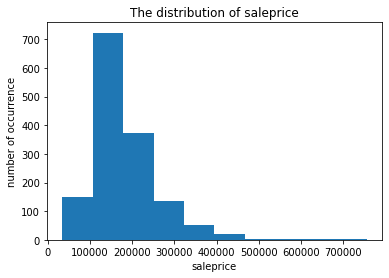

In [11]:
# checking normality of target

plt.hist(df.saleprice)
plt.title("The distribution of saleprice")
plt.xlabel("saleprice")
plt.ylabel("number of occurrence")
plt.show()
# saleprice is skewed right which is expected with the price of homes but relatively normal distribution. 

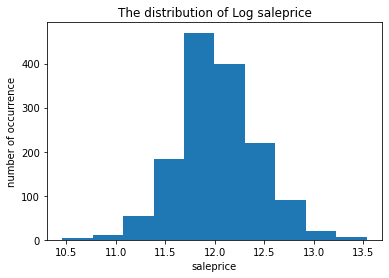

In [12]:
plt.hist(np.log(df['saleprice']))
plt.title("The distribution of Log saleprice")
plt.xlabel("saleprice")
plt.ylabel("number of occurrence")
plt.show()

In [13]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


Replacing index with id column.

In [14]:
df = df.set_index("id")
df.shape

(1460, 80)

Looking at normality of target variable, saleprice shows that it's skewed and may need to be transformed.

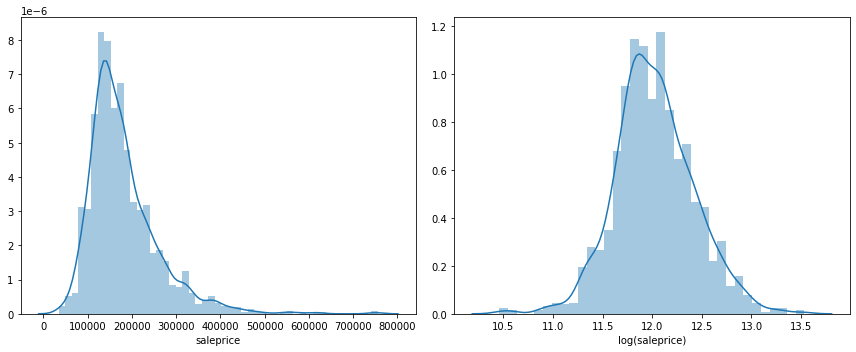

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.distplot(df["saleprice"], ax=axes[0])

sns.distplot(np.log(df["saleprice"]), ax=axes[1])
axes[1].set_xlabel("log(saleprice)")

plt.tight_layout()
plt.show()

Top correlated vars with target before transform. 

In [16]:
df.corr()['saleprice'].sort_values(ascending=False)

saleprice        1.000
overallqual      0.791
grlivarea        0.709
garagecars       0.640
garagearea       0.623
totalbsmtsf      0.614
firstflrsf       0.606
fullbath         0.561
totrmsabvgrd     0.534
yearbuilt        0.523
yearremodadd     0.507
garageyrblt      0.486
masvnrarea       0.477
fireplaces       0.467
bsmtfinsf1       0.386
lotfrontage      0.352
wooddecksf       0.324
secondflrsf      0.319
openporchsf      0.316
halfbath         0.284
lotarea          0.264
bsmtfullbath     0.227
bsmtunfsf        0.214
bedroomabvgr     0.168
screenporch      0.111
poolarea         0.092
mosold           0.046
threessnporch    0.045
bsmtfinsf2      -0.011
bsmthalfbath    -0.017
miscval         -0.021
lowqualfinsf    -0.026
yrsold          -0.029
overallcond     -0.078
mssubclass      -0.084
enclosedporch   -0.129
kitchenabvgr    -0.136
Name: saleprice, dtype: float64

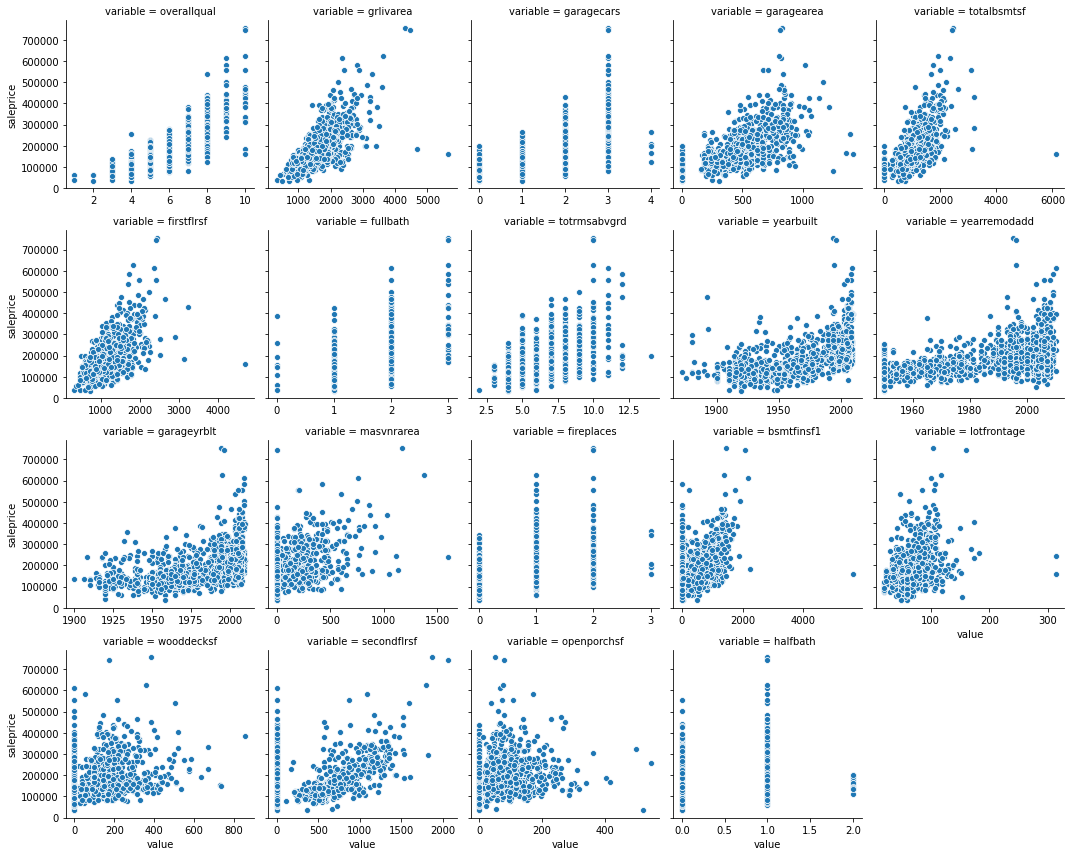

In [17]:
plot_top_corrs(df, "saleprice")

In [18]:
df['log_saleprice'] = np.log(df['saleprice'])
df = df.drop(columns='saleprice')

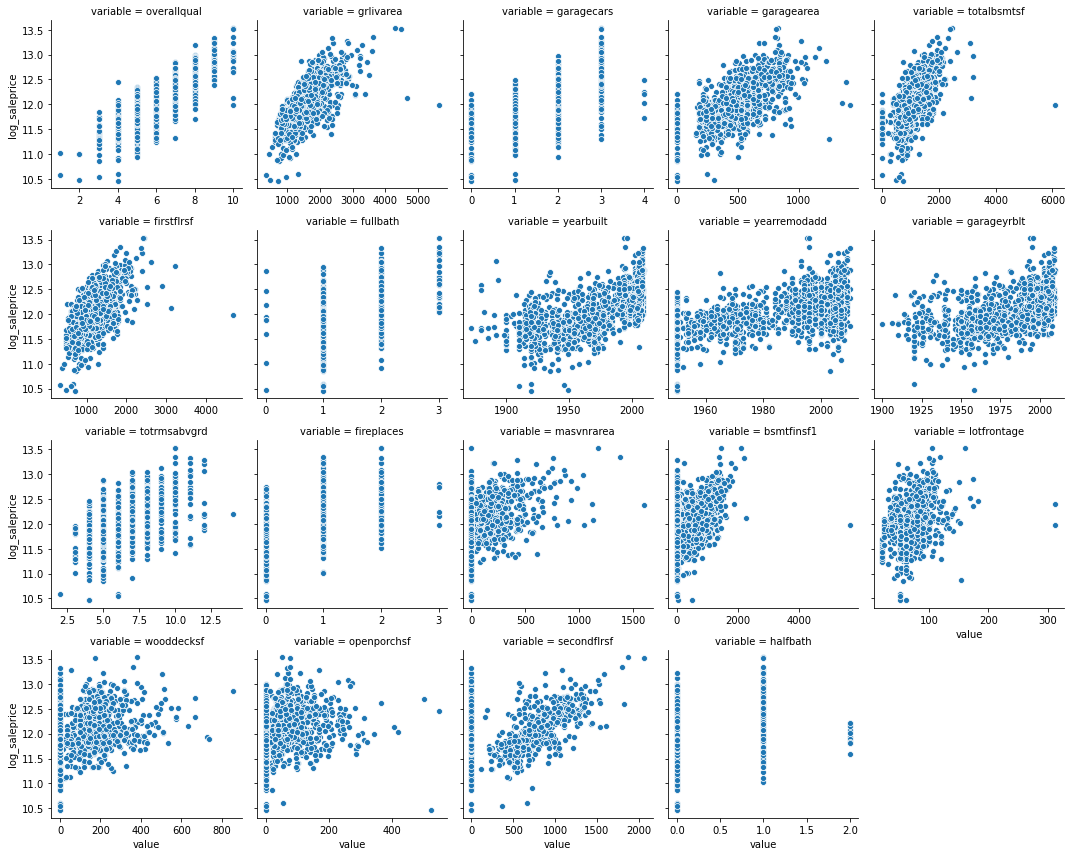

In [19]:
plot_top_corrs(df, "log_saleprice")

Drop pattern breaking outliers based on pairplot above.

In [20]:
df['firstflrsf'].sort_values(ascending=False).head(5)
df = df.drop([1299, 497, 524, 1025])

In [21]:
df['garagearea'].sort_values(ascending=False).head(10)
df = df.drop([582,1191,1062, 826])

In [22]:
df['totalbsmtsf'].sort_values(ascending=False).head(10)
df = df.drop([333])

In [23]:
df['masvnrarea'].sort_values(ascending=False).head(10)
df = df.drop([298])

In [24]:
df['lotfrontage'].sort_values(ascending=False).head(10)
df = df.drop([935])

Homes with no pools do seem to cost somewhat less but there is insufficient data to include it. Will remove poolqc.

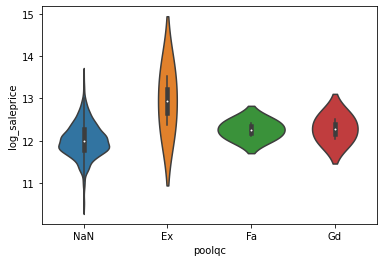

In [25]:
sns.violinplot('poolqc', 'log_saleprice', data=df.fillna('NaN'))
plt.show()

In [26]:
na_summary(df, "poolqc", additional_cols=["log_saleprice"])

log_saleprice                 
                size   mean       sum
poolqc                               
Ex                 2 12.944    25.888
Fa                 2 12.268    24.535
Gd                 2 12.287    24.574
NaN             1443 12.020 17344.493

Homes with no miscellaneous feature do not appear to cost more or less but there is insufficent data to determine so will remove.

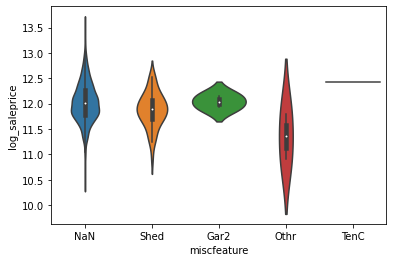

In [27]:
sns.violinplot('miscfeature', 'log_saleprice', data=df.fillna('NaN'))
plt.show()

In [28]:
na_summary(df,'miscfeature', additional_cols=['log_saleprice'])

log_saleprice                 
                     size   mean       sum
miscfeature                               
Gar2                    2 12.042    24.083
NaN                  1396 12.027 16790.017
Othr                    2 11.357    22.713
Shed                   48 11.880   570.249
TenC                    1 12.429    12.429

Fireplace quality is missing 47% of data and there is already another variable that captures number of fireplaces. Will remove. 

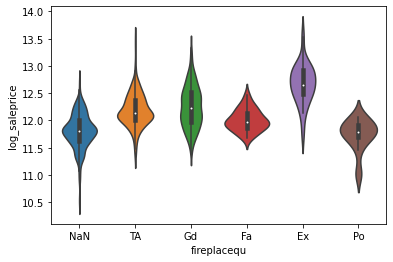

In [29]:
sns.violinplot('fireplacequ', 'log_saleprice', data=df.fillna('NaN'))
plt.show()

In [30]:
na_summary(df,'fireplacequ', additional_cols=['log_saleprice'])

log_saleprice                
                     size   mean      sum
fireplacequ                              
Ex                     24 12.670  304.080
Fa                     33 12.009  396.281
Gd                    372 12.252 4557.577
NaN                   689 11.810 8136.844
Po                     20 11.739  234.776
TA                    311 12.186 3789.932

Homes without fences are about 87% of the data and appear ot increase the value slightly but will remove to simplify.

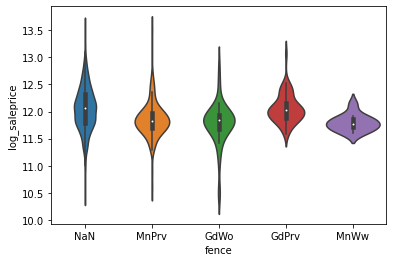

In [31]:
sns.violinplot('fence', 'log_saleprice', data=df.fillna('NaN'))
plt.show()

In [32]:
na_summary(df,'fence', additional_cols=['log_saleprice'])

log_saleprice                 
               size   mean       sum
fence                               
GdPrv            59 12.057   711.370
GdWo             54 11.784   636.349
MnPrv           157 11.851  1860.544
MnWw             11 11.797   129.765
NaN            1168 12.056 14081.464

Homes with no alley comprise 94% of the data and seem to have little impact on price so will remove.

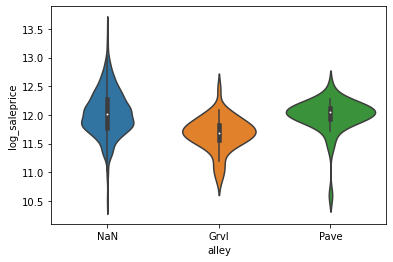

In [33]:
sns.violinplot('alley', 'log_saleprice', data=df.fillna('NaN'))
plt.show()

In [34]:
na_summary(df,'alley', additional_cols=['log_saleprice'])

log_saleprice                 
               size   mean       sum
alley                               
Grvl             50 11.673   583.668
NaN            1359 12.036 16356.338
Pave             40 11.987   479.485

In [35]:
df.shape

(1449, 80)

In [36]:
df = df.drop(columns='alley')

In [37]:
df = df.drop(columns='poolqc')

In [38]:
df = df.drop(columns='fence')

In [39]:
df = df.drop(columns='fireplacequ')

In [40]:
df = df.drop(columns='miscfeature')

In [41]:
df.shape

(1449, 75)

In [42]:
df.isnull().mean().sort_values(ascending=False).head(20)

lotfrontage     0.177
garagetype      0.056
garageyrblt     0.056
garagecond      0.056
garagequal      0.056
garagefinish    0.056
bsmtexposure    0.026
bsmtfintype1    0.026
bsmtcond        0.026
bsmtqual        0.026
bsmtfintype2    0.026
masvnrarea      0.006
masvnrtype      0.006
electrical      0.001
exterior1st     0.000
roofmatl        0.000
log_saleprice   0.000
exterior2nd     0.000
yearremodadd    0.000
exterqual       0.000
dtype: float64

Garage and basement variables are missing the same amount of data each because the house either has no basement or no garage. I'll onehot encode each variable and impute the mean for missing values in lotfrontage.

In [43]:
# dropping one null value in electrical column
df = df.drop([1380])

In [44]:
df.isnull().mean().sort_values(ascending=False).head(20)

lotfrontage    0.177
garagetype     0.056
garageyrblt    0.056
garagefinish   0.056
garagequal     0.056
garagecond     0.056
bsmtexposure   0.026
bsmtfintype2   0.026
bsmtfintype1   0.026
bsmtcond       0.026
bsmtqual       0.026
masvnrtype     0.006
masvnrarea     0.006
yearbuilt      0.000
exterqual      0.000
exterior2nd    0.000
exterior1st    0.000
extercond      0.000
foundation     0.000
bsmtfinsf1     0.000
dtype: float64

In [45]:
# filling in missing values with mean of column
df['lotfrontage'].fillna(df.lotfrontage.mean(), inplace=True)

In [46]:
df.fillna(0, inplace=True)

In [47]:
df.isnull().mean().sort_values(ascending=False).head(20)

log_saleprice   0.000
yearremodadd    0.000
roofmatl        0.000
exterior1st     0.000
exterior2nd     0.000
masvnrtype      0.000
masvnrarea      0.000
exterqual       0.000
extercond       0.000
foundation      0.000
bsmtqual        0.000
bsmtcond        0.000
bsmtexposure    0.000
bsmtfintype1    0.000
bsmtfinsf1      0.000
bsmtfintype2    0.000
bsmtfinsf2      0.000
roofstyle       0.000
yearbuilt       0.000
totalbsmtsf     0.000
dtype: float64

In [57]:
mapping = {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4}
df['bsmtqual'] = df['bsmtqual'].replace(mapping)

In [60]:
df.bsmtqual.value_counts()


3    647
2    612
1    117
0     37
4     35
Name: bsmtqual, dtype: int64

In [62]:
mapping = {'Po': 1, 'Gd': 2, 'TA': 3, 'Fa': 4}
df['bsmtcond'] = df['bsmtcond'].replace(mapping)

In [63]:
df.bsmtcond.value_counts()

3    1299
2      65
4      45
0      37
1       2
Name: bsmtcond, dtype: int64

In [64]:
df['overall_bsmt'] = df['bsmtcond'] * df['bsmtqual']

In [66]:
df.overall_bsmt.value_counts()

9     594
6     592
3     106
12     60
4      38
0      37
2      11
16      8
8       2
Name: overall_bsmt, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = TRAINtrain_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
cat_cols = ["Department"]
drop_cats = ["POLICE"]

num_cols = []

bin_cols = ["is_fulltime"]

In [ ]:
ct = ColumnTransformer(
    [("one_hot_encode", OneHotEncoder(drop=drop_cats, sparse=False), cat_cols)],
    remainder="passthrough",
)

ct.fit(X_train)

X_train = ct.transform(X_train)
X_test = ct.transform(X_test)

In [48]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scl = scaler.transform(X_train)
X_test_scl = scaler.transform(X_test)

NameError: name 'STANDStandardScaler' is not defined

In [ ]:
X_train_scl = pd.DataFrame(X_train_scl, columns=X_train.columns, index=X_train.index)
X_test_scl = pd.DataFrame(X_test_scl, columns=X_test.columns, index=X_test.index)

In [ ]:
X_train_const = sm.add_constant(X_train_scl)
X_test_const = sm.add_constant(X_test_scl)

model = sm.OLS(y_train, X_train_const).fit()
model.summary()

In [ ]:
y_pred = model.predict(X_test_const)

plt.scatter(y_test, y_pred)
plt.plot([0, 5], [0, 5], "--", c="gray")
plt.show()

In [ ]:
# null hypothesis: homoscedastic residuals
# null hypothesis: heteroscedastic residuals
_, p, _, _ = het_breuschpagan(model.resid, X_train_const)
p

# We ____ homoscedastic assumption

In [ ]:
# checking normality assumption
sm.qqplot(model.resid, line="s")
plt.show()

# We _____ normality assumption

In [ ]:
df.saleprice.valuecounts()

In [ ]:
drop_cols = ["fence", "alley", "poolqc", "fireplacequ", "miscfeature"]
df = df.drop(columns=drop_cols)
df = df.dropna()

In [ ]:
def plot_categorical(data, var):
    try:
        data = pd.concat([df['saleprice'], df[var]], axis=1)
        f, ax = plt.subplots(figsize=(20, 10))
        fig = sns.boxplot(x=var, y="saleprice", data=df)
        fig.axis(ymin=0, ymax=800000);
    except:
        pass

In [ ]:
plot_categorical(data= df, var='fence')

In [ ]:
# shows 4 graphs
X_train.hist()
plt.tight_layout()
plt.show()